# Finding different groups of exoplanets
As I mentioned in the readme.md, my research interest is transiting exoplanets. In this coding piece, I use K_means to help me find clusters in the Exoplanet dataset, grouping different types of exoplanets. The data is from the NASA Exoplanet Archive: https://exoplanetarchive.ipac.caltech.edu/index.html.

_"The NASA Exoplanet Archive is an online astronomical exoplanet and stellar catalog and data service that collates and cross-correlates astronomical data and information on exoplanets and their host stars, and provides tools to work with these data. The archive is dedicated to collecting and serving important public data sets involved in the search for and characterization of extrasolar planets and their host stars. These data include stellar parameters (such as positions, magnitudes, and temperatures), exoplanet parameters (such as masses and orbital parameters) and discovery/characterization data (such as published radial velocity curves, photometric light curves, images, and spectra)."_

In [2]:
# Import block
import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial import distance 

import time
import timeit

## Part 1: Import dataset 

The Exoplanet dataset consists of 91 variables, which have the information and the error of planet orbit period, Jupiter Mass, radius, eccentricity, and etc. Due to the limitation in astronomical observations, the dataset have many null value. I make sure the orbit period, Jupiter mass, and radius of the planet have values when I extract the dataset from NASA archive. I then extract them out of the dataset and standardize them because I would like to group them using unsupervised learning K_means.

In [3]:
# import dataset and convert to numpy array
gaia = pd.read_csv('../data/confirmed_transit.csv', comment='#')
gaia_new = gaia.loc[:,['pl_orbper','pl_bmassj','pl_radj']]
gaia_np = gaia_new.to_numpy()

# standardize gaia data
scaler = StandardScaler()
scaler.fit(gaia_new)
gaia_np_std = scaler.transform(gaia_new)

In [4]:
# overview of our dataset
gaia.shape

(1907, 91)

## Part 2: Perform K_Means and Evalution
To find the suitable number of clusters, I loop through a list of number, evaluate and compare the average distance from points to their corresponding cluster centers. I determine the best number using Elbowlogy method.

In [4]:
# Find the best number of clusters in K means
def looping_kmeans(arr,k_cluster):
    sums=[]
    
    for k in k_cluster:
        km_alg = KMeans(n_clusters=k, init="random",random_state = 1, max_iter = 300)
        fit3 = km_alg.fit(arr)
        labels = fit3.labels_
        centers = fit3.cluster_centers_

        within_cluster_sumsqs = 0
        n = 0
        for c in centers:
            # Extract the cluster's center and associated points:
            cluster_center = c.reshape(1,-1)
            cluster_points = arr[labels==n]
            n = n+1

            # Compute the following for each cluster:
            cluster_spread = distance.cdist(cluster_points, cluster_center, 'euclidean')
            cluster_total = np.sum(cluster_spread)

            # Add this cluster's within sum of squares to within_cluster_sumsqs
            within_cluster_sumsqs = within_cluster_sumsqs + cluster_total
        sums.append(within_cluster_sumsqs)
    
    return sums

The average error sums are stored in `sums`, by plotting them out I can determine the "elbow" point.

<IPython.core.display.Javascript object>


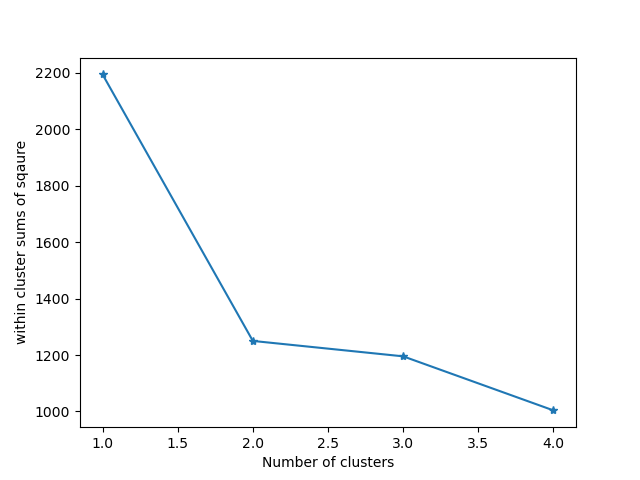

Text(0, 0.5, 'within cluster sums of sqaure')

In [5]:
# Plot the looping K_Means
plt.plot(list(range(1,5,1)),looping_kmeans(gaia_np_std,list(range(1,5,1))),"*-")
plt.xlabel("Number of clusters")
plt.ylabel("within cluster sums of sqaure")

It is clear that 2 is the elbow point because it changes most rapidly here. 

## Part 3: Perform 2 clusters K_means with from scratch algorithm and existing off the shelf implemenation

Since we now know the best number of clusters for our dataset, we can apply K_means and visualize our results. I would like to make a comparsion of my scratch implementation for K_means and the existing off-the-shelf k-means implementation. I will use `%%timeit` to compare the average running time for two implementations.

In [6]:
def kMeans(data_np, k, max_iteration):
    # Randomly select some datapoints to be the center
    idx = np.random.randint(data_np.shape[0], size=k)
    centers_np = data_np[idx,:]
    
    iteration = 0
    while iteration < max_iteration:
        
        # Calulate the distance from points to centers
        dists = distance.cdist(data_np, centers_np, 'euclidean')
        labels = np.argmin(dists, axis=1)

        # Update the centers
        for i in range(k):
            cluster = data_np[labels[:] == i]
            centers_np[i,0] = cluster[:,0].mean()
            centers_np[i,1] = cluster[:,1].mean()
        iteration += 1
    
    return centers_np,labels

In [7]:
%%timeit

# Average running time for off-the-shelf K_Means
kmeans = KMeans(n_clusters=2, random_state=0, max_iter = 300).fit(gaia_np_std)

27.3 ms ± 2.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
%%timeit

# Average running time for my scratch K_Means
mykmeans = kMeans(gaia_np_std, 2, 300)

53.3 ms ± 6.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The off-the-shelf kmeans runs 24.9 ms $\pm$ 1.67 ms per loop. The kmeans I implemented from scratch runs 50.3 ms $\pm$ 6.02 ms per loop on average. The off-the-shelf is much faster than my own implementation. Off-the-shelf KMeans selects initial cluster centers for k-mean clustering in a smart way to speed up convergence in default, while my implementation randomly select the mean clustering at the first place. This is why my implementation is slower than sklearn.

## Part 4: Plot the Exoplanets

<IPython.core.display.Javascript object>


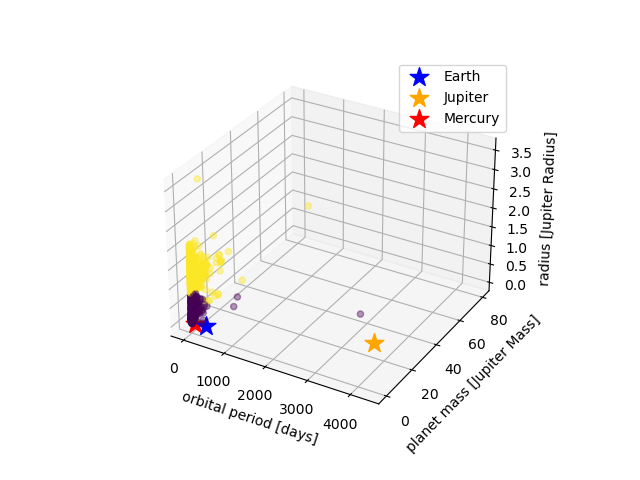

In [9]:
# extract labels and centers from 2 clusters K_Means
kmeans = KMeans(n_clusters=2, random_state=0, max_iter = 200).fit(gaia_np_std)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Plot the 3D diagram for orbit period, Jupiter Mass, and Jupiter Radius
fig = plt.figure()
ax = plt.axes(projection='3d')

# Create the SCATTER() plot 
# I choose to plot against the not standardized(original) dataset because it is more intuitive to interpret.
ax.scatter(gaia_np[:,0], gaia_np[:,1], gaia_np[:,2],c=labels,alpha=0.4);
#ax.scatter(centers[:, 0],centers[:, 1], centers[:, 2], c='red', marker="*", s=200, alpha=0.75)
ax.set_xlabel('orbital period [days]')
ax.set_ylabel('planet mass [Jupiter Mass]')
ax.set_zlabel('radius [Jupiter Radius]')

# Plot Mercury, Jupiter and Earth to the 3d plot
jup = [4332.589,1,1]
earth = [365,1/317,0.0892147]
mercury = [88,3.3010 *10**23/(1.8981*10**27),(2.4397*10**3)/(6.9911*10**4)]
ax.scatter(earth[0],earth[1],earth[2],marker="*",c="blue",s=200,label="Earth")
ax.scatter(jup[0],jup[1],jup[2],marker="*",c="orange",s=200,label="Jupiter")
ax.scatter(mercury[0],mercury[1],mercury[2],marker="*",c="red",s=200,label="Mercury")
ax.legend()

### Discussion:

- The yellow cluster of exoplanets has larger average radius than the purple cluster. Yellow group has slightly larger planet mass than purple group, and they also have a wider range of mass. Two group have similar average orbit periods, the purple group have several exceptions which have over 1000 days of orbit periods.
- By plotting the transiting Exoplanets against some planets in our Solar system, I found the purple group is closer to Earth-like planets in context of orbital period, mass and radius. The yellow group have Jupiter-like mass and radius, but Mercury-like orbital period.
- The Purple group corresponds to Super-Earth type in Exoplanets classifcation, and the yellow group corresponds to gas giant. 
    - Super-Earths are more massive than Earth yet lighter than ice giants like Neptune and Uranus, and can be made of gas, rock or a combination of both. They are between twice the size of Earth and up to 10 times its mass. 
    - Gas giant is a large planet mostly composed of helium and/or hydrogen. These planets, like Jupiter and Saturn in our solar system, don’t have hard surfaces and instead have swirling gases above a solid core. Gas giant exoplanets can be much larger than Jupiter, and much closer to their stars than anything found in our solar system(thus very short orbital periods).